In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

# import plotly.plotly as py
# import plotly.graph_objs as go
from collections import OrderedDict
from functools import reduce
import re
import glob
import os
# import subprocess
#  make standart subprocess call function because we will need it later on many occasions
# sub_run = lambda x: subprocess.run('{}'.format(x), shell=True,  stdout=subprocess.PIPE, stderr=subprocess.STDOUT)

In [5]:
from scipy import stats
from sklearn import decomposition

In [18]:
#from hicexplorer import hicExport

## To do! 
1. PCA-based treatment of fragments from sliding. We have to either fit pca models for each flattened segment tp obtain [pc1,pc2] coordinates and than plot it together, or get [pc1,pc2,...,pci] (exp_var ~ 0.9) and correlate on this data.
1.1 substitute df.corr.sum() approach by something considering directional change (upregulating or downregulating)
2. Make intersection of stable TADs and genes
3. For proximity genes make GO-annotation 
4. Do the same for Instable genes 
5. Compare GO terms.
6. Find 

### Bedtools analogue of intersection - easier to do myself than to write already wrote road
(I remained uncertain on the nature of multisected output from bedtools so decided to check myself for fully resilent regions)

In [2663]:
path_to_cools='/home/lunar/Desktop/HI-C_project/mm9_/'
path_to_beds='/home/lunar/Desktop/HI-C_project/analysis/'

In [2662]:
ls

Ba.TAD.40K_domains.bed  D8.TAD.40K_domains.bed   T_stable_40k.bed
B.TAD.40K_domains.bed   fully_constant.bed       union.TAD.bed
D2.TAD.40K_domains.bed  Genes_MM9.bed            visibleData.bed
D4.TAD.40K_domains.bed  PSC.TAD.40K_domains.bed  visibleData_Genes.bed
D6.TAD.40K_domains.bed  T


In [2664]:
## load beds
beds = {k: pd.read_csv(glob.glob(path_to_beds+'{}.*domain*'.format(k))[0], '\t', header=None) for k in list(phases.classes_)+['PSC'] }

In [2668]:
CLASSES = ['B', 'Ba', 'D2', 'D4', 'D6', 'D8', 'PSC']

In [2688]:
## append zipped (chr left right) identites of TADs
for k in CLASSES:
    beds[k]['Bounds'] = list(zip(beds[k][0].values, beds[k][1].values, beds[k][2].values))
    beds[k]['Bounds_1'] = list(zip(beds[k][0].values, beds[k][1].values))
    beds[k]['Bounds_2'] = list(zip(beds[k][0].values,  beds[k][2].values))

In [2689]:
def make_intersection(beds, selector='Bounds'):
### hmmmm, how to unpack iterable inside function not eating bundles?
    common = set.intersection( set(beds['B'][selector]), set(beds['Ba'][selector]), set(beds['D2'][selector]),
                        set(beds['D4'][selector]), set(beds['D6'][selector]), set(beds['D8'][selector]), )
    
    checker = lambda df: df[df[selector].isin(common)]
    concatenats = pd.concat(map(checker, [beds[k] for k in CLASSES])).sort_values(by=1)
### here we discard all unnesseccery column - mb we will need score at some time (20 minutes before presentation)
    concatenats = concatenats[[0,1,2]]
    concatenats = concatenats.drop_duplicates().sort_values(by=[0,1])
    return concatenats

In [2698]:
for i,j in zip( ['Conserved', 'lefts', 'rights', 'all'],[make_intersection(beds, 'Bounds').shape[0],
 make_intersection(beds, 'Bounds_1').shape[0], 
 make_intersection(beds, 'Bounds_2').shape[0], 
 beds['D4'].shape[0]]):
    print(i +":", j)

Conserved: 645
lefts: 4598
rights: 4573
all: 5658


 It's nice that numbers of TADS across samples are so close. How to get statistics based on left/right intersection?

## Attempt to get enrichment of genes

In [2579]:
#genes=pd.read_csv('/home/lunar/Desktop/mart_export(2).txt', sep='\t')

In [2592]:
#genes_sel = genes[genes['Chromosome/scaffold name'].isin( [str(x) for x in range(0,20)]+['X'])]

mb later and not in python

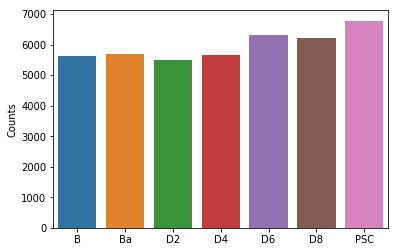

In [2699]:
tad_counts = pd.DataFrame({ k: [beds[k].shape[0], conc_link for k in list(phases.classes_)+['PSC']}, index=['Counts'])
g=sns.barplot(x=tad_counts.columns,y='Counts',data=tad_counts.T)
plt.savefig('/home/lunar/Desktop/HI-C_project/Pictures/Tads_counts.png', dpi=360)

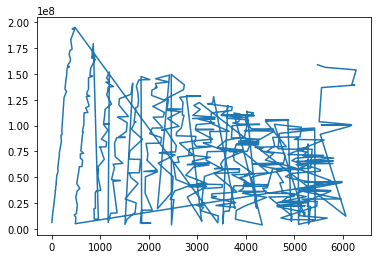

In [2278]:
plt.plot(conc_link[1])

Ghhhhhm.... looks like some regions come from wrong chromosomes...

In [2281]:
conc_link.to_csv('T_stable_40k.bed', sep='\t', index=None)

In [77]:
import cooler
%matplotlib inline

In [2705]:
cd $path_to_cools

/home/lunar/Desktop/HI-C_project/mm9_


In [2706]:
data = OrderedDict({x.split('.')[0] : cooler.Cooler(x) for x in  glob.glob('*balanced.cool')})

In [2708]:
### global but not capital
### Exclude Junk Chr
chromnames = data['B'].chromnames[:-1]

1. for individual chromosomes: extract matrices - flatten -> correlate by pearsons (expecting normal distribution) between samples - make distance matrix -> mds reverse transform - get positions on 2D. (PCA analogue).
2. Repeat for each chromosome. 
3. Combine results in one dataframe
4. Make K-means

In [107]:
from sklearn import manifold
from sklearn.preprocessing import LabelEncoder

In [320]:
phases = LabelEncoder()
phases.fit(list(data.keys()))
phases.transform(list(data.keys()))

array([0, 5, 4, 1, 3, 2])

In [ ]:
def combine_region_flat(data, reg):
    combined = pd.DataFrame({x: np.log1p(data[x].matrix().fetch(reg).flatten()) for x in data.keys()},) 
                            #index=range(0, data['B'].extent(reg)[1]))
    return combined

In [344]:
def make_mds(corr_chr, reg):
    model =  manifold.MDS(n_components=2, n_init=15, eps=10e-4, dissimilarity='precomputed', random_state=1)
    out = model.fit_transform(corr_chr)
    return pd.DataFrame(out, index= list(map(lambda x: x+'.'+reg, corr_chr.index)), columns=['mds1', 'mds2'])

In [2710]:
def make_pca(region_flat_df, reg):
    pca_mod = decomposition.PCA(n_components=2)
    pcad_region = pca_mod.fit_transform(region_flat_df.T.values, CLASSES  )
    return pd.DataFrame(pcad_region, index=list(map(lambda x: x+'.'+reg, region_flat_df.columns)), columns=['PC1', 'PC2'])

In [2714]:
def denoize(region_flat_df):
    pca_mod = decomposition.PCA(n_components=0.9)
    out = pca_mod.fit_transform(region_flat_df.T.values, CLASSES )
### denoize
    resolved_region = pca_mod.inverse_transform(out)
    return pd.DataFrame(resolved_region, columns=region_flat_df.index)

In [2715]:
def iterate_through_all(data, chromnames):
    Res = OrderedDict({})
    for chr_i in chromnames:
        c_region = combine_region_flat(data, chr_i)
        c_region = c_region.dropna(how='all').fillna(0)
        mds_df = make_mds(c_region.corr(), chr_i)
        pca_r  = make_pca(c_region, chr_i) 
        denoized = denoize(c_region)
        Res.update({chr_i : {'mds':mds_df}})
        Res[chr_i].update({'pcaed':pca_r})
       # Res[chr_i].update({'denoized':denoized})
    return Res

In [2716]:
Res = iterate_through_all(data, chromnames)

In [2720]:
#Res['chr1']['mds']
#Res['chr1']['pcaed']

In [2610]:
######### Show that rectangles are much easier to 
exp_var = []
for i in range(0,200):
    model = decomposition.PCA(n_components=i)
    fd = model.fit_transform(d)
    exp_var.append(model.explained_variance_ratio_.sum())

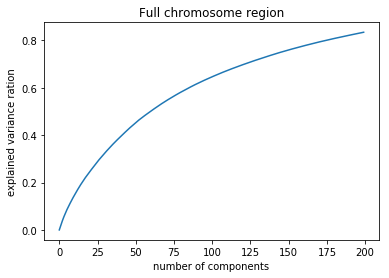

In [2619]:
plt.plot(exp_var)
plt.title('Full chromosome region')
plt.xlabel('number of components')
plt.ylabel('explained variance ration')
plt.savefig('../Pictures/PCA_explained_var_F_400k.png', dpi=360)

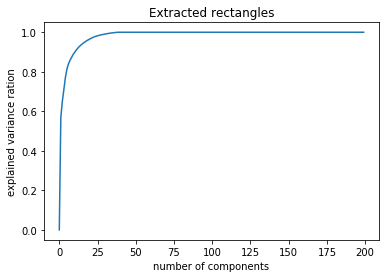

In [2618]:
d=rectangles['chr1']['Ba']
exp_var_rec = []
for i in range(0,200):
    model_rec = decomposition.PCA(n_components=i)
    fd = model_rec.fit_transform(d)
    exp_var_rec.append(model_rec.explained_variance_ratio_.sum())
plt.plot(exp_var_rec)
plt.title('Extracted rectangles')
plt.xlabel('number of components')
plt.ylabel('explained variance ration')
plt.savefig('../Pictures/PCA_explained_var_R_400k.png', dpi=360)

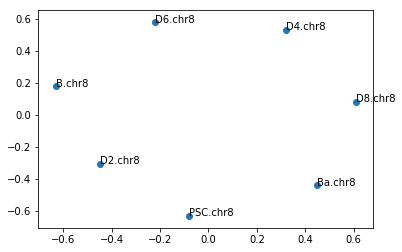

In [2722]:
### some scatter_plots which look quite dim
### Why B and Ba are always on the far ends&!
plot_scatter(Res['chr8']['mds'])

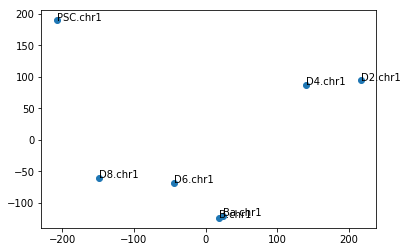

In [2723]:
### With PSC scatterplots go out of control (that's why we should delete themmmmm)
plot_scatter(Res['chr1']['pcaed'])

In [2009]:
#plt.scatter( Res['chr1']['pcaed'].values[:, 0],  Res['chr1']['pcaed'].values[:, 1], c=[0,1,2,3,4,5])

In [2803]:
def plot_pcX(PcX, dims, name, n=2,  key='sample', key_col='PC'):
    for i in range(1,n):
        P = PcX.ix[:,i-1:i+1].join(PcX.ix[:,-1])
        g = sns.FacetGrid(PcX, size=6,  hue=key,)
        g = (g.map(plt.scatter, key_col+"{}".format(i), key_col+"{}".format(i+1), edgecolor="w", alpha=0.99, s=90,).add_legend())
        plt.title(name)
        plt.show()

In [2054]:
import matplotlib.patches as mpatches

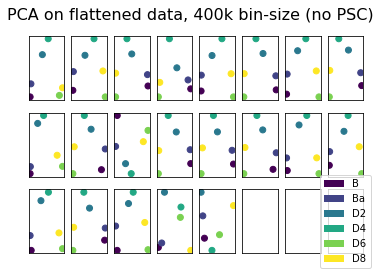

In [2349]:
fig, ax = plt.subplots(3, 8, subplot_kw=dict(xticks=[], yticks=[]), )
labels = phases.classes_
for k, axi in zip( Res.keys(), ax.flat):
#     axi.scatter() imshow(faces.images[i], cmap='gray')
    axi.scatter( Res[k]['pcaed'].values[:, 0],  Res[k]['pcaed'].values[:, 1], 
                c=[0,1,2,3,4,5], )
recs = []
for i in range(0,len(phases.classes_)):
    recs.append(mpatches.Rectangle((0,0),0.8,0.8,fc=[cmap(i) for i in np.linspace(0,1,6)][i],))
plt.legend(recs, phases.classes_, loc=10)
plt.suptitle('PCA on flattened data, 400k bin-size (no PSC)', fontsize=16)
plt.savefig('PCA_400k.png', dpi=360)

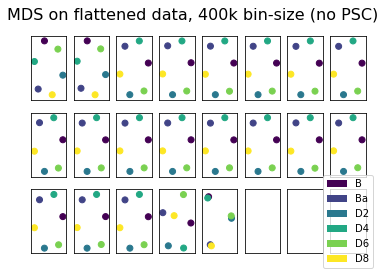

In [2351]:
fig, ax = plt.subplots(3, 8, subplot_kw=dict(xticks=[], yticks=[]))
labels = phases.classes_
for k, axi in zip( Res.keys(), ax.flat):
#     axi.scatter() imshow(faces.images[i], cmap='gray')
    axi.scatter( Res[k]['mds'].values[:, 0],  Res[k]['mds'].values[:, 1], c=[0,1,2,3,4,5])
recs = []
for i in range(0,len(phases.classes_)):
    recs.append(mpatches.Rectangle((0,0),0.8,0.8,fc=[cmap(i) for i in np.linspace(0,1,6)][i],))
plt.legend(recs, phases.classes_, loc=10)
plt.suptitle('MDS on flattened data, 400k bin-size (no PSC)', fontsize=16)
plt.savefig('/home/lunar/Desktop/HI-C_project/Pictures/MDS_400k.png', dpi=360)

In [405]:
def plot_scatter(mds_out):
    out, label  = mds_out.values, mds_out.index
    fig, ax = plt.subplots()
    plt.scatter(out[:, 0], out[:, 1], )
    for i, l in enumerate(label):
            ax.annotate(l, (out[i, 0], out[i, 1]))

In [2764]:
def concat_all(res_dict):
    for i,chr_i in enumerate(res_dict.keys()):
        res_dict[chr_i]['mds']['chr']=[i+1]*res_dict[chr_i]['mds'].shape[0]
    r = pd.concat( [ res_dict[x]['mds'] for x in res_dict.keys()])
    return r

In [2766]:
# stacked mds distances
Res_combined = concat_all(Res)
### add sample stage label
Res_combined['phase'] = [x.split('.')[0] for x in Res_combined.index]

In [2784]:
X = Res_combined

In [ ]:
plot_pcX(X, dims=1, name='N', key='phase', key_col='mds')

We can select central part with gaussian mixture/hbdscan/ and try to find what makes thouse chromosomes more similar to same chrmosomes in other samples.

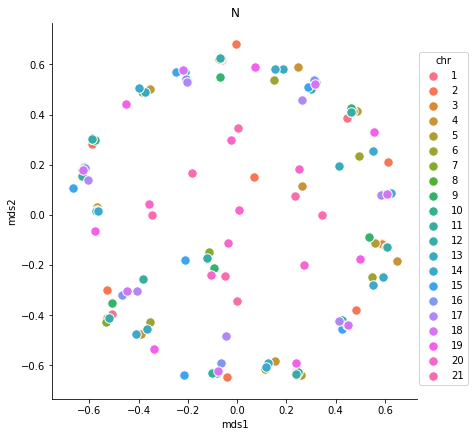

In [2805]:
plot_pcX(X, dims=1, name='N', key='chr', key_col='mds')

#### I think we have to add shapes somehow to sns.  mb after rotation this data will be in perfect complience.

In [ ]:
colorize = dict(c= Res_combined.values [:, 0], cmap=plt.cm.get_cmap('rainbow', 18))

In [444]:
c = data['B'].matrix()

In [1685]:
offset = 10e-1
test_chr = data['B'].matrix().fetch('chr1') + offset

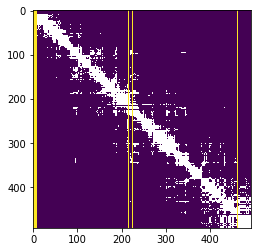

In [2353]:
### test 'softmax' just for fun!
plt.imshow(10*np.exp(test_chr)/np.exp(test_chr).sum(axis=0))
plt.savefig('/home/lunar/Desktop/HI-C_project/Pictures/Bizzare_and_beautiful.png', dpi=360)

In [1968]:
def extract_(z, depth_d=40):
    shortest = int(z.diagonal(offset=depth_d).shape[0]/2)
    Extract = np.ndarray([depth_d, shortest*2])
    for I, i in enumerate(range(0,depth_d)):
        c = z.diagonal(offset=i)
        c_ = c[ int(c.shape[0]/2)-shortest : int(c.shape[0]/2)+shortest]
        Extract[i,:] = c_
#     soft_max_w = Extract.sum(axis=1)/(Extract.sum(axis=1).sum())
#     soft_max_w = np.exp(soft_max_w)/(np.exp(soft_max_w).sum())
    return Extract

In [1969]:
#extract_(np.log1p( data['B'].matrix().fetch('chr2')))

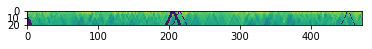

In [1938]:
plt.imshow(Extract)

In [2557]:
rectangles = {}
for chr_i in chromnames:
    rectangles.update( {chr_i: {x: extract_( np.log1p(data[x].matrix().fetch(chr_i)), depth_d=40) for x in data.keys()}})

In [671]:
## rectangle_corr = rectangles.corr()
## clustermap on rectangles looks slightly different, but close
#sns.clustermap(rectangle_corr)

### Sliding window approach
1. PCA - fit on all concatenated rectangels of choosen window size -> go through them once more -> extract PC1 which hopefully will separate to types of cells -> make correlation on pcaed rectange windows

In [ ]:
### I need to slice each sample, each chromosome to chunks of universal length and perform on them pca.

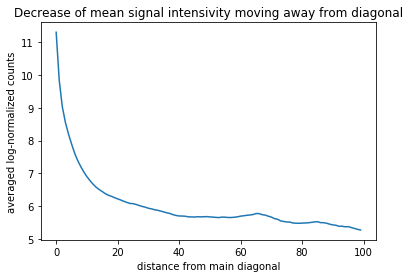

In [2553]:
plt.plot(rectangles['chr2']['B'].mean(axis=1))
plt.title('Decrease of mean signal intensivity moving away from diagonal')
plt.xlabel('distance from main diagonal')
plt.ylabel('averaged log-normalized counts')
plt.savefig('/home/lunar/Desktop/HI-C_project/Pictures/Decrease_of_sig.png', dpi=360)

In [2561]:
def slide(rec_chr, depth=40, half_window_size=10, step=5,  ):
    length = rec_chr['B'].shape[1]
    Binded = np.ndarray([7, int(length/step), int(2*half_window_size*depth)])
    for n, k, in enumerate(rec_chr.keys()):
        for i in range( 1, int(length/step)):
            c_ = rec_chr[k][:, i*step-half_window_size : i*step + half_window_size].flatten()
            if c_.shape[0] != Binded.shape[2]:
                print(i, c_.shape[0], Binded.shape[2])
                c_ = np.zeros( Binded.shape[2])
            elif i==1 or 1==int(length/step):
                 c_ = np.zeros( Binded.shape[2])
            Binded[n,i,:]= c_
#     Binded = np.array(Binded)
    return Binded

In [1973]:
def chrom_similarities(recs, **kwargs):
    chrom_sims = {}
    m_std = lambda x: (x.mean(), x.std())
    
    def filter_nans(x):
        if np.isnan(x[0]):
            x = [0.5, 0.5] 
        return x
    
    for chr_i in recs.keys():
        slider = slide(recs[chr_i], **kwargs)
        profile = np.array([ filter_nans( m_std(np.tril(pd.DataFrame(slider[:,i,:]).T.corr().values, k=-1,))) for i in range(slider.shape[1])]) 
        chrom_sims.update({chr_i: profile})
    return chrom_sims

## Make sliding correlation signal

In [2562]:
offset_from_start = 20
Half_window_size = 5
Step = 5
depth = 40
bin_size = 400000
###################
Threshhold = 0.32

In [2563]:
sims = chrom_similarities(rectangles, 
                depth=depth, half_window_size=Half_window_size, step=Step)

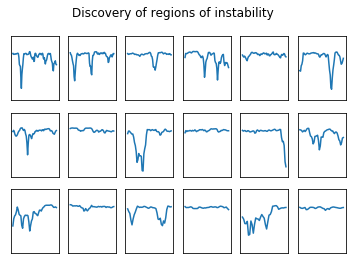

In [2567]:
fig, ax = plt.subplots(3, 6, subplot_kw=dict(xticks=[], yticks=[]))
#labels = phases.classes_
for k, axi in zip( sims.keys(), ax.flat):
#     axi.scatter() imshow(faces.images[i], cmap='gray')
    axi.plot( sims[k][2:,0],) #c=[0,1,2,3,4])
    axi.set_ylim([0.2, 0.5])
# fig.text(0.5, 0.04, 'Mean corr' , ha='center', va='center')
# fig.text(0.06, 0.5, 'intra-chromosome location', ha='center', va='center', rotation='vertical')

plt.suptitle('Discovery of regions of instability')
plt.savefig('/home/lunar/Desktop/HI-C_project/Pictures/Unstable_400k_3_3.png', dpi=360)

Text(0.5,0.98,'Statistics of correlation analysis')

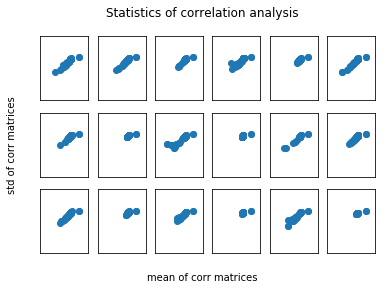

In [2572]:
fig, ax = plt.subplots(3, 6, subplot_kw=dict(xticks=[], yticks=[]))
#labels = phases.classes_
for k, axi in zip( sims.keys(), ax.flat):
#     axi.scatter() imshow(faces.images[i], cmap='gray')
    axi.scatter( sims[k][0:,0], sims[k][0:,1]  , ) #c=[0,1,2,3,4])
    axi.set_xlim([0.1, 0.6])
    axi.set_ylim([0.1, 0.7])
fig.text(0.5, 0.04, 'mean of corr matrices' , ha='center', va='center')
fig.text(0.06, 0.5, 'std of corr matrices', ha='center', va='center', rotation='vertical')

plt.suptitle('Statistics of correlation analysis')
#plt.savefig('/home/lunar/Desktop/HI-C_project/Pictures/Unstable_Scatter_400k_3_3.png', dpi=360)

### simple stats

In [2638]:
#68000/22, 5600/22

(3090.909090909091, 254.54545454545453)

In [2640]:
a =np.ndarray(3090) 

In [2644]:
a[np.random.choice(3090, 255)]=1

In [2649]:
coins = []
for i in range(1000):
    a = np.zeros(3090) 
    a[np.random.choice(3090, 265)]=1
    b = np.zeros(3090) 
    b[np.random.choice(3090, 265)]=1
    coins.append(np.sum(a+b == 2))

In [2653]:
np.array(coins).mean(), 645/22

(20.905000000000001, 29.318181818181817)

In [ ]:
def chrom_similarities(recs, **kwargs):
    chrom_sims = {}
    m_std = lambda x: (x.mean(), x.std())
    
    def filter_nans(x):
        if np.isnan(x[0]):
            x = [0.5, 0.5] 
        return x
    for chr_i in recs.keys():
        slider = slide(recs[chr_i], **kwargs)
        
        
        profile = np.array([ filter_nans( m_std(np.tril(pd.DataFrame(slider[:,i,:]).T.corr().values, k=-1,))) for i in range(slider.shape[1])]) 
        chrom_sims.update({chr_i: profile})
    return chrom_sims

In [2807]:
# from matplotlib import offsetbox

# def plot_components(data, model, images=None, ax=None,
#                     thumb_frac=0.05, cmap='gray'):
#     ax = ax or plt.gca()
    
#     proj = model.fit_transform(data)
#     ax.plot(proj[:, 0], proj[:, 1], '.k')
    
#     if images is not None:
#         min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
#         shown_images = np.array([2 * proj.max(0)])
#         for i in range(data.shape[0]):
#             dist = np.sum((proj[i] - shown_images) ** 2, 1)
#             if np.min(dist) < min_dist_2:
#                 # don't show points that are too close
#                 continue
#             shown_images = np.vstack([shown_images, proj[i]])
#             imagebox = offsetbox.AnnotationBbox(
#                 offsetbox.OffsetImage(images[i], cmap=cmap),
#                                       proj[i])
#             ax.add_artist(imagebox)

In [1585]:
return_centers = lambda x: x*step+20
return_left = lambda x: x*step+20-half_window_size
return_right = lambda x: x*step+20+half_window_size

In [1588]:
from scipy import ndimage

In [1644]:
def make_bed_instab(sims, thresh):   
    future_bed = []
    for chr_i in sims.keys():
        try:
            c = sims[chr_i][:,0]<thresh
            labels, numL = ndimage.label(c)
            label_indices = [(labels == i).nonzero() for i in range(1, numL+1)]
            for region in label_indices:
                future_bed.append( [chr_i, return_left(region[0])[0], return_right(region[-1])[0]])
        except IndexError:
            print(chr_i)
    return future_bed

In [1660]:
def make_actual_bed(name, future_bed, bin_size):
    bed = []
    for l in future_bed:
        l[1]*=bin_size
        l[2]*=bin_size
        bed.append( '\t'.join( map(str, l)))
    with open(name, 'w') as f:
        f.write( '\n'.join(bed))
    return bed

In [1984]:
b_ = make_bed_instab(sims, Threshhold)

chrY


In [2541]:
make_actual_bed('Instab_Regions_400k_29_new_F.bed', b_, bin_size)

['chr1\t30400000000000\t33600000000000',
 'chr2\t1600000000000\t4800000000000',
 'chr2\t16000000000000\t19200000000000',
 'chr2\t65600000000000\t68800000000000',
 'chr3\t1600000000000\t4800000000000',
 'chr4\t1600000000000\t4800000000000',
 'chr4\t52800000000000\t56000000000000',
 'chr5\t1600000000000\t4800000000000',
 'chr6\t1600000000000\t4800000000000',
 'chr6\t4800000000000\t8000000000000',
 'chr6\t75200000000000\t78400000000000',
 'chr7\t1600000000000\t4800000000000',
 'chr8\t1600000000000\t4800000000000',
 'chr9\t22400000000000\t25600000000000',
 'chr9\t27200000000000\t30400000000000',
 'chr10\t1600000000000\t4800000000000',
 'chr11\t1600000000000\t4800000000000',
 'chr11\t81600000000000\t84800000000000',
 'chr12\t1600000000000\t4800000000000',
 'chr13\t1600000000000\t4800000000000',
 'chr13\t20800000000000\t24000000000000',
 'chr13\t35200000000000\t38400000000000',
 'chr14\t1600000000000\t4800000000000',
 'chr15\t1600000000000\t4800000000000',
 'chr15\t11200000000000\t1440000000

## Large Files with manly resolutions

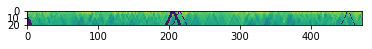

In [607]:
def make_extracts(df):
    extracts = {}
    for c in df.columns:
        extracts.update({c: extract_(df[c])})
        

In [2391]:
z0 = np.zeros(z.shape)

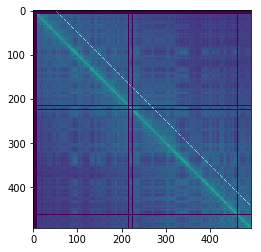

In [2418]:
plt.imshow(z+10*np.eye(z.shape[0], z.shape[1], 50)**100)
plt.savefig('/home/lunar/Desktop/HI-C_project/Pictures/Boundary_of_rectang.png', dpi=360)

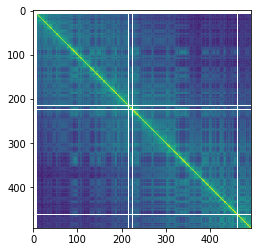

In [449]:
plt.imshow( np.log10(data['B'].matrix().fetch('chr1')) )

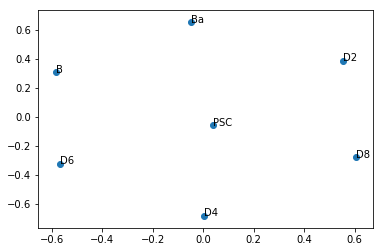

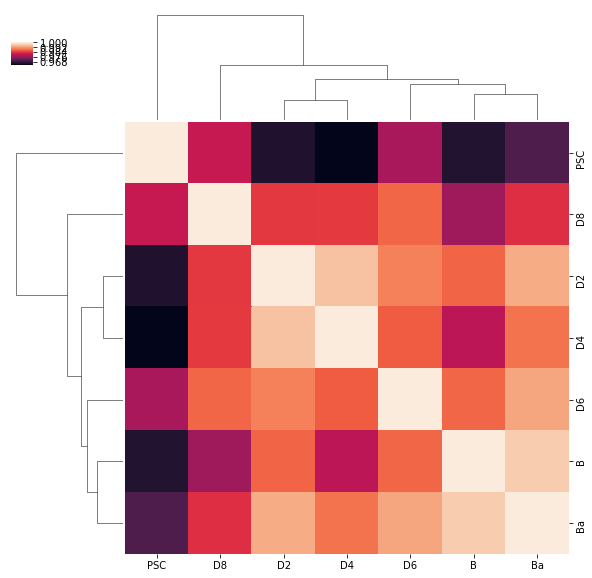

In [126]:
model =  manifold.MDS(n_components=2, n_init=10, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(corr_c1)